**Tarea 6 Analisis de Imagenes con redes convolucionales**

Jose Alberto Lopez Alvarez
Mat. 1553133

Importamos algunas librerias de manipulacion e importacion de datos

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
import os

Como se esta trabajando en colab usamos la siguiente funcion para cargar las imagenes al ambiente

In [6]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving Tiger_001.jpg to Tiger_001.jpg
Saving Tiger_002.jpg to Tiger_002.jpg
Saving Tiger_003.jpg to Tiger_003.jpg
Saving Tiger_004.jpg to Tiger_004.jpg
Saving Tiger_005.jpg to Tiger_005.jpg
Saving Tiger_006.jpg to Tiger_006.jpg
Saving Tiger_007.jpg to Tiger_007.jpg
Saving Tiger_008.jpg to Tiger_008.jpg
Saving Tiger_009.jpg to Tiger_009.jpg
Saving Tiger_010.jpg to Tiger_010.jpg
Saving Tiger_011.jpg to Tiger_011.jpg
Saving Tiger_012.jpg to Tiger_012.jpg
Saving Tiger_013.jpg to Tiger_013.jpg
Saving Tiger_014.jpg to Tiger_014.jpg
Saving Tiger_015.jpg to Tiger_015.jpg
Saving Tiger_016.jpg to Tiger_016.jpg
Saving Tiger_017.jpg to Tiger_017.jpg
Saving Tiger_018.jpg to Tiger_018.jpg
Saving Tiger_019.jpg to Tiger_019.jpg
Saving Tiger_020.jpg to Tiger_020.jpg
Saving Tiger_021.jpg to Tiger_021.jpg
Saving Tiger_022.jpg to Tiger_022.jpg
Saving Tiger_023.jpg to Tiger_023.jpg
Saving Tiger_024.jpg to Tiger_024.jpg
Saving Tiger_025.jpg to Tiger_025.jpg
Saving Tiger_026.jpg to Tiger_026.jpg
Saving Tiger

El siguiente comando se usa para quitar un archivo que se crea en las carpetas que se utilizan en colab y que no permite correr la funcion para leer y juntar las imagenes

In [7]:
rmdir /content/Felidae/Puma/.ipynb_checkpoints

In [8]:
os.chdir('/content/Felidae')

In [9]:
data = []
target = []
new_size = (224,224)

# iteracion entre carpetas
for folder in os.listdir():
    os.chdir(folder)
    for file in os.listdir():
        # abre cada imagen y la escala
        img = PIL.Image.open(file)
        img_res = np.array(img.resize(new_size))
        
        # junta las imagenes y las etiqueta
        data.append(img_res)
        target.append(folder)
    os.chdir('..')

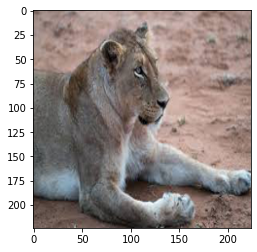

In [10]:
plt.imshow(data[1])

Importamos las librerias para el preprocesado y modelaje

In [11]:
import tensorflow as tf
from tensorflow import keras
import argparse
from imutils import paths
import cv2

In [12]:
from tensorflow.keras import backend as K
from tensorflow.keras import utils as np_utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import  ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [13]:
print(data)

[array([[[173, 149, 125],
        [173, 151, 126],
        [173, 152, 127],
        ...,
        [142, 116,  84],
        [131, 103,  71],
        [140, 107,  79]],

       [[174, 151, 126],
        [176, 154, 129],
        [175, 154, 129],
        ...,
        [148, 121,  89],
        [129, 104,  72],
        [127, 101,  70]],

       [[169, 151, 125],
        [174, 155, 130],
        [176, 156, 131],
        ...,
        [151, 124,  91],
        [134, 112,  79],
        [119, 101,  68]],

       ...,

       [[134, 119,  97],
        [133, 115,  93],
        [137, 116,  94],
        ...,
        [ 83,  60,  57],
        [ 88,  66,  62],
        [ 86,  66,  62]],

       [[129, 114,  92],
        [138, 120,  99],
        [149, 128, 107],
        ...,
        [ 93,  65,  63],
        [106,  79,  76],
        [ 97,  76,  71]],

       [[124, 109,  89],
        [135, 117,  99],
        [135, 117,  97],
        ...,
        [ 96,  69,  66],
        [105,  79,  76],
        [101,  82,  75]

In [14]:
data[10].shape

(224, 224, 3)

Validamos que no tengamos errores en los index

In [15]:
try:
    data = np.array(data)
    target = np.array(target)
except:
    print('Problem with broadcast')

Problem with broadcast


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [16]:
wrong_imgs_idx = []
# Validamos que todas las imagenes esten en RGB y juntamos los index incorrectos
# checking if all pics are in RGB and adding incorrect indexes to list
for idx,img in enumerate(data):
    try:
        if img.shape[2] != 3:
            wrong_imgs_idx.append(idx)
    except:
        if len(img.shape) != 3:
            wrong_imgs_idx.append(idx)

In [17]:
wrong_imgs_idx

[48, 97]

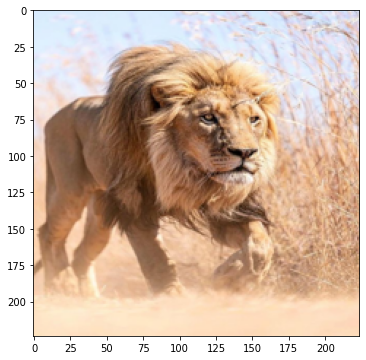

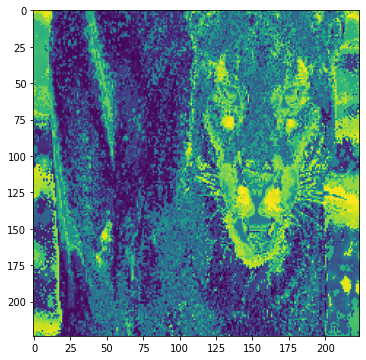

In [18]:
# mostramos las imagenes incorrectas
for idx in wrong_imgs_idx:
    plt.figure(figsize=(6,6))
    plt.imshow(data[idx])

In [19]:
# quitamos la imagenes que no esten en RGB
a = 0
for idx in wrong_imgs_idx:
    del data[idx-a]
    del target[idx-a]
    a += 1

In [20]:
try:
    data = np.array(data)
    target = np.array(target)
except:
    print('Problem with broadcast')

In [21]:
print(data.shape)
print(target.shape)

(241, 224, 224, 3)
(241,)


Para el preprocesado, creamos las etiquetas y hacemos la transformacion con la funcion de sklearn: LabelEncoder

In [22]:
from sklearn.preprocessing import LabelEncoder

lbl = LabelEncoder()
target_n = lbl.fit_transform(target)

In [23]:
target_n[:5]

array([2, 2, 2, 2, 2])

Separacion del conjunto de entrenamiento y conjunto de prueba, en esta parte se probo con un test_size de 0.15, 0.2, 0.25 el que mejor se ajuste fue el de 0.25

In [24]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

x_train, x_test, y_train, y_test = train_test_split(data,target_n,test_size=0.25,stratify=target)

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (180, 224, 224, 3)
x_test shape: (61, 224, 224, 3)
y_train shape: (180,)
y_test shape: (61,)


In [25]:
x_train_n = x_train / 255
x_test_n = x_test / 255
y_train_cat = to_categorical(y_train,num_classes=len(set(y_train)))
y_test_cat = to_categorical(y_test,num_classes=len(set(y_test)))

definicion de los kernel

In [26]:
y_train_cat[:5]

array([[1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

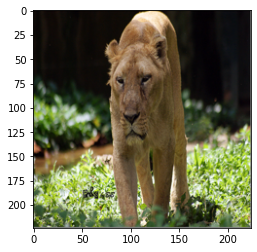

In [27]:
plt.imshow(x_train_n[1])

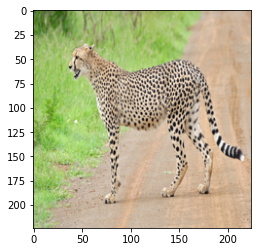

In [28]:
plt.imshow(x_train_n[10])

In [29]:
y_test_cat[:5]

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

A continuacion definimos las capas y redes que se usaran para el modelo, aqui se probo quitando capas y ampliando redes

In [30]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers,optimizers
from tensorflow.keras.callbacks import TensorBoard,ModelCheckpoint,EarlyStopping


def model_create():
    model = Sequential()
    model.add(layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu',input_shape=x_train_n[0].shape,
                                 padding='same'))
    model.add(layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu', padding='same'))
    model.add(layers.MaxPool2D(pool_size=(3,3)))
    model.add(layers.Dropout(0.15))

    model.add(layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu', padding='same'))
    model.add(layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu', padding='same'))
    model.add(layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu', padding='same'))
    model.add(layers.MaxPool2D(pool_size=(3,3)))
    model.add(layers.Dropout(0.15))

    model.add(layers.Conv2D(filters=256,kernel_size=(3,3),activation='relu', padding='same'))
    model.add(layers.Conv2D(filters=256,kernel_size=(3,3),activation='relu', padding='same'))
    model.add(layers.Conv2D(filters=256,kernel_size=(3,3),activation='relu', padding='same'))
    model.add(layers.MaxPool2D(pool_size=(3,3)))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(units=1024,activation='relu'))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(units=128,activation='relu'))
    model.add(layers.Dense(units=5,activation='softmax'))
    return model

model = model_create()

In [31]:
model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 74, 74, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 74, 74, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 74, 74, 128)       147584    
                                                        

Preparamos el modelo el cual se probo con 20, 50 y 100 epochs

In [32]:
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

In [34]:
es = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=50,restore_best_weights=True)

history = model.fit(x_train_n, y_train_cat,epochs=100,validation_data=(x_test_n, y_test_cat), callbacks=[es])

Epoch 1/100
6/6 [==============================] - 131s 22s/step - loss: 11.1797 - accuracy: 0.1722 - val_loss: 1.6477 - val_accuracy: 0.1639
Epoch 2/100
6/6 [==============================] - 133s 23s/step - loss: 1.6374 - accuracy: 0.2500 - val_loss: 1.6029 - val_accuracy: 0.2295
Epoch 3/100
6/6 [==============================] - 131s 22s/step - loss: 1.4511 - accuracy: 0.3722 - val_loss: 1.6172 - val_accuracy: 0.2295
Epoch 4/100
6/6 [==============================] - 133s 21s/step - loss: 1.6530 - accuracy: 0.3222 - val_loss: 1.6190 - val_accuracy: 0.1967
Epoch 5/100
6/6 [==============================] - 138s 23s/step - loss: 1.5974 - accuracy: 0.3556 - val_loss: 1.6079 - val_accuracy: 0.2951
Epoch 6/100
6/6 [==============================] - 131s 22s/step - loss: 1.4404 - accuracy: 0.3833 - val_loss: 1.5983 - val_accuracy: 0.2131
Epoch 7/100
6/6 [==============================] - 128s 21s/step - loss: 1.4967 - accuracy: 0.4222 - val_loss: 1.6329 - val_accuracy: 0.1967
Epoch 8/100


In [35]:
y_pred = model.predict(x_test_n).argmax(1)
y_true = y_test

In [36]:
import seaborn as sns
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,classification_report
set(lbl.inverse_transform(y_test))

{'Cheetah', 'Leopard', 'Lion', 'Puma', 'Tiger'}

In [37]:
classes = ['Cheetah', 'Leopard', 'Lion', 'Puma', 'Tiger']

Text(0.5, 15.0, 'Prediccion')

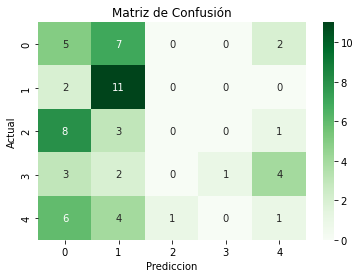

In [38]:
confusion_matrix(y_pred=y_pred,y_true=y_true)
p = sns.heatmap(pd.DataFrame(confusion_matrix(y_pred=y_pred,y_true=y_true)), annot=True, cmap="Greens" ,fmt='g')
plt.title('Matriz de Confusión', y=1.1)
plt.ylabel('Actual')
plt.xlabel('Prediccion')

In [39]:
print('Model 1: \n',classification_report(y_true=y_true,y_pred=y_pred,target_names=classes))

Model 1: 
               precision    recall  f1-score   support

     Cheetah       0.21      0.36      0.26        14
     Leopard       0.41      0.85      0.55        13
        Lion       0.00      0.00      0.00        12
        Puma       1.00      0.10      0.18        10
       Tiger       0.12      0.08      0.10        12

    accuracy                           0.30        61
   macro avg       0.35      0.28      0.22        61
weighted avg       0.32      0.30      0.23        61



Conclusiones: el modelo no esta ajustando bien en la parte de la prueba a pesar de modificaciones en las redes y en el conjunto de datos, la razon por la que no esta ajustando bien pareciera estar relacionada a la falta de informacion, es decir, tenemos muy pocas imagenes para cada categoria.

**Tarea 7 Analisis de Imagenes con Transfer Learning**

Jose Alberto Lopez Alvarez

Mat. 15553133

Utilizaremos Transfer Learning para modelar la clasificacion de las imagenes a traves del modelo: VGG16, pero antes incrementaremos la cantidad de datos para no toparnos con la problematica del modelado anterior, utilizaremos un modelo de tensorflow de data augmentation: ImageDataGenerator

In [40]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest', 
    validation_split = .25
)

valid_datagen = ImageDataGenerator(
    rescale=1./255, 
    validation_split = .25
)

data_dir = '/content/Felidae'

train_data = train_datagen.flow_from_directory(data_dir, target_size = new_size, class_mode = 'categorical',
                                        subset = 'training')

val_data = valid_datagen.flow_from_directory(data_dir, target_size = new_size, class_mode = 'categorical',
                                        subset = 'validation')

Found 183 images belonging to 5 classes.
Found 60 images belonging to 5 classes.


In [41]:
from keras.applications.vgg16 import VGG16
from keras.models import Model

vgg16 = VGG16(input_shape=x_train_n[0].shape, weights='imagenet',include_top=False)

for layer in vgg16.layers:
    layer.trainable = False

58900480/58889256 [==============================] - 0s 0us/step


In [42]:
x1 = layers.Flatten()(vgg16.output)
x2 = layers.Dense(5,activation='softmax')(x1)

model2 = Model(inputs=vgg16.input,outputs=x2)

In [43]:
model2.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

In [44]:
history = model2.fit_generator(
    generator=train_data,
    validation_data=val_data,
    epochs=100,
    callbacks=es
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/100
6/6 [==============================] - 131s 22s/step - loss: 5.7091 - accuracy: 0.2842 - val_loss: 7.7206 - val_accuracy: 0.2000
Epoch 2/100
6/6 [==============================] - 141s 24s/step - loss: 3.2902 - accuracy: 0.3169 - val_loss: 2.1898 - val_accuracy: 0.3833
Epoch 3/100
6/6 [==============================] - 129s 22s/step - loss: 2.1493 - accuracy: 0.3770 - val_loss: 1.8943 - val_accuracy: 0.4667
Epoch 4/100
6/6 [==============================] - 130s 23s/step - loss: 1.2975 - accuracy: 0.5464 - val_loss: 1.1822 - val_accuracy: 0.6000
Epoch 5/100
6/6 [==============================] - 128s 22s/step - loss: 1.5672 - accuracy: 0.5355 - val_loss: 2.1313 - val_accuracy: 0.5500
Epoch 6/100
6/6 [==============================] - 129s 23s/step - loss: 1.9017 - accuracy: 0.5191 - val_loss: 0.9457 - val_accuracy: 0.6000
Epoch 7/100
6/6 [==============================] - 128s 22s/step - loss: 2.0506 - accuracy: 0.4536 - val_loss: 1.1697 - val_accuracy: 0.6667
Epoch 8/100
6

In [45]:
y_pred = model.predict(x_test_n).argmax(1)
y_pred2 = model2.predict(x_test_n).argmax(1)
y_true = y_test

In [46]:
import seaborn as sns
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,classification_report
set(lbl.inverse_transform(y_test))

{'Cheetah', 'Leopard', 'Lion', 'Puma', 'Tiger'}

In [47]:
classes = ['Cheetah', 'Leopard', 'Lion', 'Puma', 'Tiger']

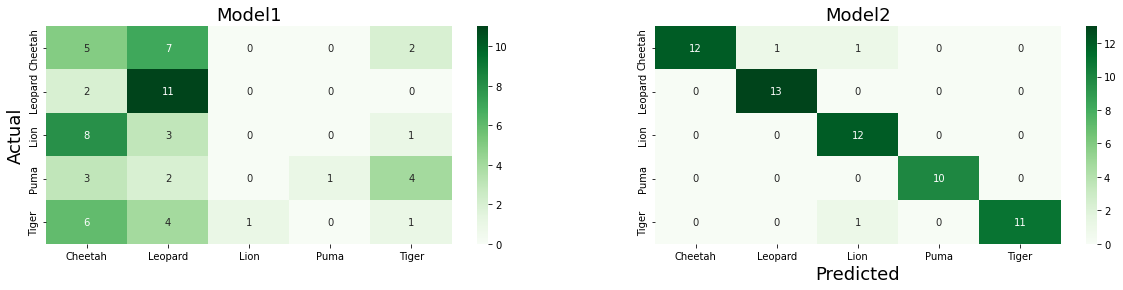

In [48]:
con_matrixes = [confusion_matrix(y_pred=y_pred,y_true=y_true),
                confusion_matrix(y_pred=y_pred2,y_true=y_true)]

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(20,4))
for i in range(2):
    sns.heatmap(con_matrixes[i],cmap='Greens',annot=True,fmt='g',ax=ax[i])
    ax[i].set_title('Model'+str(i+1),size=18)
    ax[i].set_xticklabels(classes)
    ax[i].set_yticklabels(classes)
ax[0].set_ylabel('Actual',size=18)
ax[1].set_xlabel('Predicted',size=18)
plt.show()

In [49]:
print('Model 2: \n',classification_report(y_true=y_true,y_pred=y_pred2,target_names=classes))

Model 2: 
               precision    recall  f1-score   support

     Cheetah       1.00      0.86      0.92        14
     Leopard       0.93      1.00      0.96        13
        Lion       0.86      1.00      0.92        12
        Puma       1.00      1.00      1.00        10
       Tiger       1.00      0.92      0.96        12

    accuracy                           0.95        61
   macro avg       0.96      0.95      0.95        61
weighted avg       0.96      0.95      0.95        61



Conclusiones: El modelo de transfer learning con aumento de datos se ajusto mucho mejor llegando a un accuracy de 0.95, practicamente todas las categorias las ajusta muy bien. El val_accuracy tambien mejoro bastante, la funcion stop early nos regresa los mejores pesos a los que podriamos llegar en los epochs usados, el cual alcanzo un 0.76.